# **Inspektion av datan**

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


(60000, 28, 28)


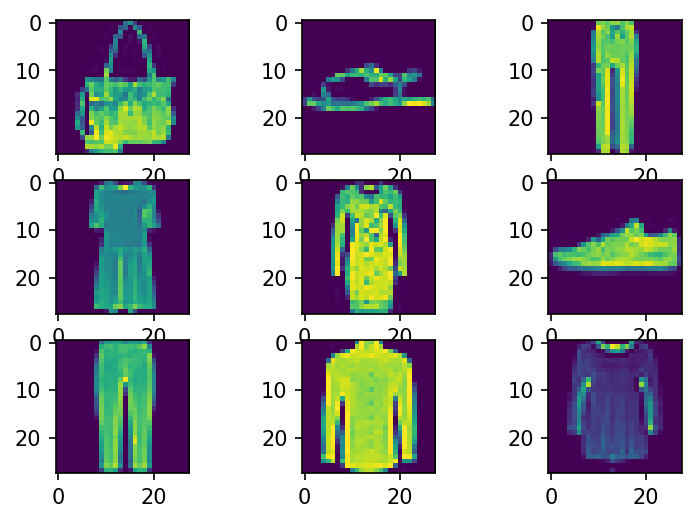

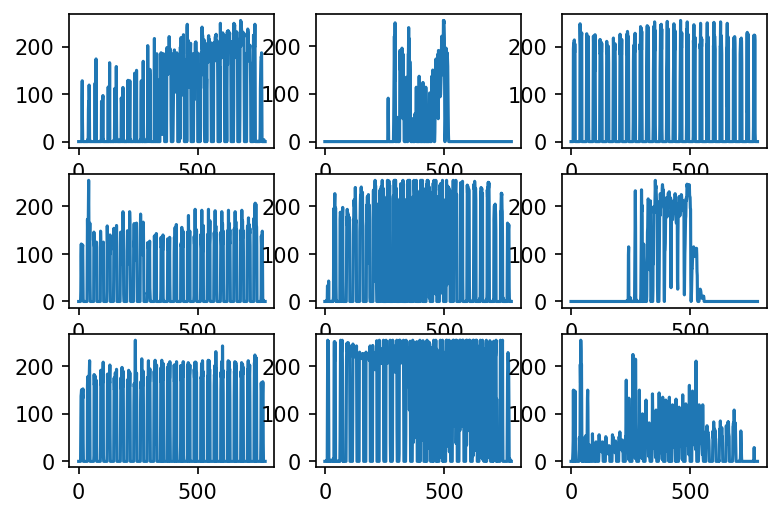

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

print(x_train.shape)
samples_to_show = 9
grid_shape = [3,samples_to_show//3]
sample_index = np.random.choice(60000, samples_to_show)


fig, axes = plt.subplots(grid_shape[0], grid_shape[1], dpi= 150)

axes = axes.reshape(-1)
for i in range(len(axes)):
  axes[i].imshow(x_train[sample_index[i],:])


number_of_pixels = x_train[0,:].size #Should be 28*28
fig2, axes2 = plt.subplots(grid_shape[0], grid_shape[1], dpi = 150)
axes2 = axes2.reshape(-1)
for i in range(len(axes)):
  axes2[i].plot(np.arange(number_of_pixels), tf.reshape(x_train[sample_index[i],:], [number_of_pixels]))

# Klassificering med PCA och FPCA av hela datasetet.
Läser in datan och separerar det i träningsdata och valideringsdata.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

train_coeff_pca = np.load("train_coeff_pca_cut.npy")
eigen_coeffs_matrix_entire_dataset = np.load("eigen_coeffs_matrix_entire_dataset.npy")
train_labels = np.load("train_labels.npy")

In [ ]:
train_size = 50000
number_of_eigenvals = 20

In [ ]:
#Only eigencoeffs
train_X_PCA = train_coeff_pca[0:train_size, 0:(number_of_eigenvals)]
val_X_PCA = train_coeff_pca[train_size:60000, 0:(number_of_eigenvals)]

train_X_FPCA = eigen_coeffs_matrix_entire_dataset[0:train_size,0:(number_of_eigenvals)]
val_X_FPCA = eigen_coeffs_matrix_entire_dataset[train_size:60000,0:(number_of_eigenvals)]

Skapar modeller för PCA och FPCA:

In [ ]:
model_PCA = keras.Sequential([
                          keras.layers.Dense(10*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                          keras.layers.Dense(10*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                          keras.layers.Dense(10, activation = 'softmax')
])
model_PCA.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_FPCA = keras.Sequential([
                          keras.layers.Dense(10*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                          keras.layers.Dense(10*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                          keras.layers.Dense(10, activation = 'softmax')
])
model_FPCA.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

**Tränar modellen på PCA-datan:**

In [ ]:
history_PCA = model_PCA.fit(train_X_PCA, train_labels[0:train_size], validation_data = (val_X_PCA, train_labels[train_size:60000]), epochs = 20)

**Tränar modellen på FPCA-datan:**

In [ ]:
history_FPCA = model_FPCA.fit(train_X_FPCA, train_labels[0:train_size], validation_data = (val_X_FPCA, train_labels[train_size:60000]), epochs = 20)

**Experimentella resultat:**

20 epochs, (om man ökar epochs till 40 brukar resultaten bli ~1% bättre)

activation: relu

Layers: 
Dense 10*#princ. comps. 

Dense 10*#princ. comps. 

Dense 10, act: softmax

***Training accuracy and validation accuracy:***

**5 pc:**

PCA: 65.95%, 65.61%

FPCA: 56.58%, 56.39%


**10 pc:**

PCA: 75.89%, 74.77%

FPCA: 72.88%, 72.26%

**20 pc:**

PCA: 82.67%, 81.18%

FPCA: 78.27%, 78.14%?

**30 pc:**

PCA: 83.80%, 83.56%

FPCA: 81.49%, 80.72%

----------------------------------

Layers: 
Dense 20*#princ. comps. 

Dense 20*#princ. comps. 

Dense 10, act: softmax

***Training accuracy and validation accuracy:***

**20 pc:**

PCA: 82.27%, 81.30%

FPCA: 77.87%, 77.54%

------------------------------------

Layers: 
Dense 10*#princ. comps. 

Dense 10*#princ. comps. 

Dense 10*#princ. comps. 

Dense 10, act: softmax

***Training accuracy and validation accuracy:***

**20 pc:**

PCA: 82.35%, 81.68%

FPCA: 77.41%, 76.71%





In [ ]:
history_PCA.history['val_accuracy'][-1]

0.8224999904632568

# Korsvalidering av ordinär F-/PCA och neuronnät

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend
import gc
train_coeff_pca = np.load("normalized_pca_coeffs_matrix_entire_dataset.npy")
#train_coeff_fpca = np.load("normalized_principal_coeffs_matrix_entire_dataset.npy")
train_labels = np.load("train_labels.npy")
#normalized_eigen_coeffs = np.load("normalized_eigen_coeffs_matrix_cut.npy")

In [ ]:
print(train_coeff_pca.shape)
#print(train_coeff_fpca.shape)
#print(eigen_coeffs_matrix_entire_dataset.shape)
#print(normalized_eigen_coeffs.shape)

(60000, 100)


###Korsvalidering av PCA och NN
Inspekterar koefficienterna för att se att de har medelvärde 0 och varians 1

1.1202890467150912e-16
1.000000000000002


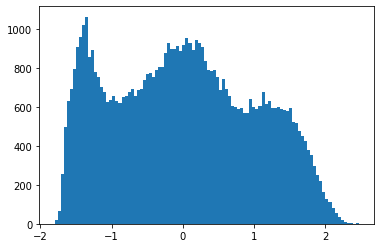

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_coeff_pca[:,0],bins = 100)
print(np.mean(train_coeff_pca[:,0])) #Should be ~0 if data is correct
print(np.var(train_coeff_pca[:,0], ddof = 1)) #Should be ~1 if data is correct
plt.show()

In [ ]:
K = 10
principal_choices = [5, 10, 20, 30, 40, 60, 80]
#StratifiedKFold bevarar klassbalans, dvs varje klass är ~1/10 av varje fold.
skf = StratifiedKFold(n_splits = K, shuffle = True, random_state=500)

history_PCA = {}





for number_of_eigenvals in principal_choices:
  h = []
  model_layers = [keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(10, activation = 'softmax')]
  for train_index, test_index in skf.split(train_coeff_pca, train_labels):
    #print("Train: ", train_index, "TEST: ", test_index)
    x_train, x_test = train_coeff_pca[train_index, 0:(number_of_eigenvals)], train_coeff_pca[test_index, 0:(number_of_eigenvals)]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    model = None
    model = keras.Sequential(model_layers)
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    h.append(model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, verbose = 0))
    print("Accuracy with {} PC: {:.2f}%".format(number_of_eigenvals,100*h[-1].history['accuracy'][-1]))
    del model
    backend.clear_session()
    gc.collect()
  history_PCA[number_of_eigenvals] = h


Accuracy with 5 PC: 72.47%
Accuracy with 5 PC: 73.37%
Accuracy with 5 PC: 73.67%
Accuracy with 5 PC: 73.80%
Accuracy with 5 PC: 74.16%
Accuracy with 5 PC: 74.14%
Accuracy with 5 PC: 74.23%
Accuracy with 5 PC: 74.22%
Accuracy with 5 PC: 74.18%
Accuracy with 5 PC: 74.40%
Accuracy with 10 PC: 79.69%
Accuracy with 10 PC: 80.39%
Accuracy with 10 PC: 80.71%
Accuracy with 10 PC: 80.88%
Accuracy with 10 PC: 81.15%
Accuracy with 10 PC: 81.44%
Accuracy with 10 PC: 81.21%
Accuracy with 10 PC: 81.40%
Accuracy with 10 PC: 81.47%
Accuracy with 10 PC: 81.45%
Accuracy with 20 PC: 83.59%
Accuracy with 20 PC: 84.01%
Accuracy with 20 PC: 84.43%
Accuracy with 20 PC: 84.59%
Accuracy with 20 PC: 84.80%
Accuracy with 20 PC: 84.99%
Accuracy with 20 PC: 84.65%
Accuracy with 20 PC: 85.01%
Accuracy with 20 PC: 84.93%
Accuracy with 20 PC: 85.11%
Accuracy with 30 PC: 84.72%
Accuracy with 30 PC: 85.05%
Accuracy with 30 PC: 85.43%
Accuracy with 30 PC: 85.46%
Accuracy with 30 PC: 85.73%
Accuracy with 30 PC: 85.87%
Ac

###Korsvalidering av FPCA och NN

In [ ]:
K = 10
principal_choices = [5, 10, 20, 30, 40, 60, 80]
#StratifiedKFold bevarar klassbalans, dvs varje klass är ~1/10 av varje fold.
skf = StratifiedKFold(n_splits = K, shuffle = True, random_state=500)

history_FPCA = {}





for number_of_eigenvals in principal_choices:
  h = []
  model_layers = [keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(10, activation = 'softmax')]
  for train_index, test_index in skf.split(train_coeff_fpca, train_labels):
    #print("Train: ", train_index, "TEST: ", test_index)
    x_train, x_test = train_coeff_fpca[train_index, 0:(number_of_eigenvals)], train_coeff_fpca[test_index, 0:(number_of_eigenvals)]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    model = None
    model = keras.Sequential(model_layers)
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    h.append(model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, verbose = 0))
    print("Accuracy with {} PC: {:.2f}%".format(number_of_eigenvals,100*h[-1].history['accuracy'][-1]))
    del model
    backend.clear_session()
    gc.collect()
  history_FPCA[number_of_eigenvals] = h

Accuracy with 5 PC: 72.53%
Accuracy with 5 PC: 73.24%
Accuracy with 5 PC: 73.70%
Accuracy with 5 PC: 73.84%
Accuracy with 5 PC: 73.85%
Accuracy with 5 PC: 73.96%
Accuracy with 5 PC: 74.00%
Accuracy with 5 PC: 74.21%
Accuracy with 5 PC: 74.06%
Accuracy with 5 PC: 74.23%
Accuracy with 10 PC: 79.84%
Accuracy with 10 PC: 80.52%
Accuracy with 10 PC: 80.90%
Accuracy with 10 PC: 81.13%
Accuracy with 10 PC: 81.37%
Accuracy with 10 PC: 81.36%
Accuracy with 10 PC: 81.45%
Accuracy with 10 PC: 81.55%
Accuracy with 10 PC: 81.70%
Accuracy with 10 PC: 81.57%
Accuracy with 20 PC: 83.52%
Accuracy with 20 PC: 83.92%
Accuracy with 20 PC: 84.26%
Accuracy with 20 PC: 84.37%
Accuracy with 20 PC: 84.81%
Accuracy with 20 PC: 84.96%
Accuracy with 20 PC: 84.91%
Accuracy with 20 PC: 84.95%
Accuracy with 20 PC: 84.98%
Accuracy with 20 PC: 84.99%
Accuracy with 30 PC: 84.64%
Accuracy with 30 PC: 84.94%
Accuracy with 30 PC: 85.14%
Accuracy with 30 PC: 85.15%
Accuracy with 30 PC: 85.47%
Accuracy with 30 PC: 85.61%
Ac

###Genomsnittliga resultat med korsvalidering av ordinär F-/PCA och neuronnät

In [ ]:
for pc, h in history_PCA.items():
  mean_accuracy = 0
  mean_val_accuracy = 0
  for CV_run in h:
    mean_accuracy += CV_run.history['accuracy'][-1]/K
    mean_val_accuracy += CV_run.history['val_accuracy'][-1]/K
  print("PCA mean CV-accuracy with {} PC:     {:.2f}%,   val_accuracy:   {:.2f}%".format(pc, 100*mean_accuracy,100*mean_val_accuracy))


PCA mean CV-accuracy with 5 PC:     73.86%,   val_accuracy:   73.91%
PCA mean CV-accuracy with 10 PC:     80.98%,   val_accuracy:   80.68%
PCA mean CV-accuracy with 20 PC:     84.61%,   val_accuracy:   84.60%
PCA mean CV-accuracy with 30 PC:     85.60%,   val_accuracy:   85.52%
PCA mean CV-accuracy with 40 PC:     86.25%,   val_accuracy:   86.19%
PCA mean CV-accuracy with 60 PC:     86.77%,   val_accuracy:   86.51%
PCA mean CV-accuracy with 80 PC:     87.13%,   val_accuracy:   86.75%


In [ ]:
for pc, h in history_FPCA.items():
  mean_accuracy = 0
  mean_val_accuracy = 0
  for CV_run in h:
    mean_accuracy += CV_run.history['accuracy'][-1]/K
    mean_val_accuracy += CV_run.history['val_accuracy'][-1]/K
  print("FPCA mean CV-accuracy with {} PC:     {:.2f}%,   val_accuracy:   {:.2f}%".format(pc, 100*mean_accuracy,100*mean_val_accuracy))


FPCA mean CV-accuracy with 5 PC:     73.76%,   val_accuracy:   73.87%
FPCA mean CV-accuracy with 10 PC:     81.14%,   val_accuracy:   80.65%
FPCA mean CV-accuracy with 20 PC:     84.57%,   val_accuracy:   84.36%
FPCA mean CV-accuracy with 30 PC:     85.39%,   val_accuracy:   85.31%
FPCA mean CV-accuracy with 40 PC:     86.10%,   val_accuracy:   85.78%
FPCA mean CV-accuracy with 60 PC:     86.67%,   val_accuracy:   86.31%
FPCA mean CV-accuracy with 80 PC:     86.67%,   val_accuracy:   86.37%


# Korsvalidering av klassvis F-/PCA och neuronnät

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
import tensorflow as tf
from tensorflow import keras

train_labels = np.load("train_labels.npy")
train_coeff_pca_cw = np.load("normalized_pca_coeffs_matrix.npy")
train_coeff_fpca_cw = np.load("normalized_principal_coeffs_matrix.npy")
print(train_coeff_pca_cw.shape)
print(train_coeff_fpca_cw.shape)

(60000, 800)
(60000, 800)


###Korsvalidering av klassvis FPCA och NN:

In [ ]:
K = 10
principal_choices = [3, 5, 10, 20, 30, 40, 60, 80]
#StratifiedKFold bevarar klassbalans, dvs varje klass är ~1/10 av varje fold.
skf = StratifiedKFold(n_splits = K, shuffle = True, random_state=500)

history_FPCA_Classwise = {}


for number_of_eigenvals in principal_choices:
  h = []
  model_layers = [keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(10, activation = 'softmax')]
  for train_index, test_index in skf.split(train_coeff_fpca_cw, train_labels):
    #print("Train: ", train_index, "TEST: ", test_index)
    #The 10 first columns corresponds to the largest principal component of each
    x_train, x_test = train_coeff_fpca_cw[train_index, 0:(10*number_of_eigenvals)], train_coeff_fpca_cw[test_index, 0:(10*number_of_eigenvals)]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    model = None
    model = keras.Sequential(model_layers)
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    h.append(model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, verbose = 0))
    print("Accuracy with {} PC: {:.2f}%".format(number_of_eigenvals,100*h[-1].history['accuracy'][-1]))
    del model
    backend.clear_session()
    gc.collect()
  history_FPCA_Classwise[number_of_eigenvals] = h
for pc, h in history_FPCA_Classwise.items():
  mean_accuracy = 0
  mean_val_accuracy = 0
  for CV_run in h:
    mean_accuracy += CV_run.history['accuracy'][-1]/K
    mean_val_accuracy += CV_run.history['val_accuracy'][-1]/K
  print("FPCA mean CV-accuracy with {} PC:     {:.2f}%,   val_accuracy:   {:.2f}%".format(pc, 100*mean_accuracy,100*mean_val_accuracy))

Accuracy with 3 PC: 78.40%
Accuracy with 3 PC: 80.03%
Accuracy with 3 PC: 80.62%
Accuracy with 3 PC: 80.93%
Accuracy with 3 PC: 81.43%
Accuracy with 3 PC: 81.63%
Accuracy with 3 PC: 81.70%
Accuracy with 3 PC: 81.86%
Accuracy with 3 PC: 81.86%
Accuracy with 3 PC: 81.83%
Accuracy with 5 PC: 81.24%
Accuracy with 5 PC: 82.14%
Accuracy with 5 PC: 82.54%
Accuracy with 5 PC: 82.64%
Accuracy with 5 PC: 83.18%
Accuracy with 5 PC: 83.08%
Accuracy with 5 PC: 83.19%
Accuracy with 5 PC: 83.25%
Accuracy with 5 PC: 83.42%
Accuracy with 5 PC: 83.50%
Accuracy with 10 PC: 83.25%
Accuracy with 10 PC: 83.82%
Accuracy with 10 PC: 84.24%
Accuracy with 10 PC: 84.33%
Accuracy with 10 PC: 84.48%
Accuracy with 10 PC: 84.57%
Accuracy with 10 PC: 84.69%
Accuracy with 10 PC: 84.69%
Accuracy with 10 PC: 84.81%
Accuracy with 10 PC: 84.45%
Accuracy with 20 PC: 84.34%
Accuracy with 20 PC: 84.86%
Accuracy with 20 PC: 85.18%
Accuracy with 20 PC: 85.31%
Accuracy with 20 PC: 85.32%
Accuracy with 20 PC: 85.35%
Accuracy wit

###Korsvalidering av klassvis PCA och NN:

In [ ]:
K = 10
principal_choices = [3, 5, 10, 20, 30, 40, 60, 80]
#StratifiedKFold bevarar klassbalans, dvs varje klass är ~1/10 av varje fold.
skf = StratifiedKFold(n_splits = K, shuffle = True, random_state=500)

history_PCA_Classwise = {}


for number_of_eigenvals in principal_choices:
  h = []
  model_layers = [keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(10, activation = 'softmax')]
  for train_index, test_index in skf.split(train_coeff_pca_cw, train_labels):
    #print("Train: ", train_index, "TEST: ", test_index)
    #The 10 first columns corresponds to the largest principal component of each
    x_train, x_test = train_coeff_pca_cw[train_index, 0:(10*number_of_eigenvals)], train_coeff_pca_cw[test_index, 0:(10*number_of_eigenvals)]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    model = None
    model = keras.Sequential(model_layers)
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    h.append(model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, verbose = 0))
    print("Accuracy with {} PC: {:.2f}%".format(number_of_eigenvals,100*h[-1].history['accuracy'][-1]))
    del model
    backend.clear_session()
    gc.collect()
  history_PCA_Classwise[number_of_eigenvals] = h

for pc, h in history_PCA_Classwise.items():
  mean_accuracy = 0
  mean_val_accuracy = 0
  for CV_run in h:
    mean_accuracy += CV_run.history['accuracy'][-1]/K
    mean_val_accuracy += CV_run.history['val_accuracy'][-1]/K
  print("PCA mean CV-accuracy with {} PC:     {:.2f}%,   val_accuracy:   {:.2f}%".format(pc, 100*mean_accuracy,100*mean_val_accuracy))

Accuracy with 3 PC: 77.86%
Accuracy with 3 PC: 79.67%
Accuracy with 3 PC: 80.56%
Accuracy with 3 PC: 80.82%
Accuracy with 3 PC: 81.30%
Accuracy with 3 PC: 81.29%
Accuracy with 3 PC: 81.26%
Accuracy with 3 PC: 81.51%
Accuracy with 3 PC: 81.62%
Accuracy with 3 PC: 81.62%
Accuracy with 5 PC: 81.57%
Accuracy with 5 PC: 82.65%
Accuracy with 5 PC: 83.00%
Accuracy with 5 PC: 82.97%
Accuracy with 5 PC: 83.23%
Accuracy with 5 PC: 83.45%
Accuracy with 5 PC: 83.39%
Accuracy with 5 PC: 83.45%
Accuracy with 5 PC: 83.44%
Accuracy with 5 PC: 83.67%
Accuracy with 10 PC: 83.44%
Accuracy with 10 PC: 83.81%
Accuracy with 10 PC: 84.25%
Accuracy with 10 PC: 84.16%
Accuracy with 10 PC: 84.29%
Accuracy with 10 PC: 84.35%
Accuracy with 10 PC: 84.47%
Accuracy with 10 PC: 84.53%
Accuracy with 10 PC: 84.92%
Accuracy with 10 PC: 84.73%
Accuracy with 20 PC: 84.69%
Accuracy with 20 PC: 85.04%
Accuracy with 20 PC: 85.36%
Accuracy with 20 PC: 85.03%
Accuracy with 20 PC: 85.53%
Accuracy with 20 PC: 85.48%
Accuracy wit

In [ ]:
for pc, h in history_PCA_Classwise.items():
  mean_accuracy = 0
  mean_val_accuracy = 0
  for CV_run in h:
    mean_accuracy += CV_run.history['accuracy'][-1]/K
    mean_val_accuracy += CV_run.history['val_accuracy'][-1]/K
  print("PCA mean CV-accuracy with {} PC:     {:.2f}%".format(pc, 100*mean_accuracy))
  print("PCA mean CV-val_accuracy with {} PC: {:.2f}%".format(pc, 100*mean_val_accuracy))
for pc, h in history_FPCA_Classwise.items():
  mean_accuracy = 0
  mean_val_accuracy = 0
  for CV_run in h:
    mean_accuracy += CV_run.history['accuracy'][-1]/K
    mean_val_accuracy += CV_run.history['val_accuracy'][-1]/K
  print("FPCA mean CV-accuracy with {} PC:     {:.2f}%".format(pc, 100*mean_accuracy))
  print("FPCA mean CV-val_accuracy with {} PC: {:.2f}%".format(pc, 100*mean_val_accuracy))

# Träning på hela datasetet och med slutgiltig testdata

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend
import gc
train_coeff_pca = np.load("train_coeff_pca_cut.npy")
train_coeff_fpca = np.load("eigen_coeffs_matrix_entire_dataset.npy")
train_coeff_pca_classwise = np.load("train_coeff_pca_classwise.npy")
train_normalized_eigen_coeffs = np.load("normalized_eigen_coeffs_matrix.npy")

test_coeff_pca = np.load("test_coeff_pca_cut.npy")
test_coeff_fpca = np.load("test_eigen_coeffs_matrix_entire_dataset.npy")
test_coeff_pca_classwise = np.load("test_coeff_pca_classwise.npy")
test_normalized_eigen_coeffs = np.load("normalized_test_eigen_coeffs.npy") 


In [ ]:
train_labels = np.load("train_labels.npy")
test_labels = np.load("test_labels.npy")

In [ ]:
print(train_coeff_pca.shape)
print(train_coeff_fpca.shape)
print(train_coeff_pca_classwise.shape)
print(train_normalized_eigen_coeffs.shape)

(60000, 80)
(60000, 80)
(60000, 800)
(60000, 800)


###Ordinär PCA och NN

In [ ]:
train_coeff_pca = np.load("normalized_pca_coeffs_matrix_entire_dataset.npy")
test_coeff_pca = np.load("test_normalized_pca_coeffs_matrix_entire_dataset.npy")
print(np.mean(train_coeff_pca[:,0]))
print(np.var(train_coeff_pca[:,0], ddof = 1))
print(train_coeff_pca.shape)
print(test_coeff_pca.shape)

1.1202890467150912e-16
1.000000000000002
(60000, 100)
(10000, 100)


In [ ]:
principal_choices = [5, 10, 20, 30, 40, 60, 80]
history_PCA_test = {}

for number_of_eigenvals in principal_choices:
  h = []
  model_layers = [keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(10, activation = 'softmax')]
  #print("Train: ", train_index, "TEST: ", test_index)
  x_train, x_test = train_coeff_pca[:,0:number_of_eigenvals], test_coeff_pca[:,0:number_of_eigenvals]
  y_train, y_test = train_labels, test_labels
  model = None
  model = keras.Sequential(model_layers)
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  h = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, verbose = 0)
  print("Training accuracy with {} PC: {:.2f}%, Test accuracy: {:.2f}%".format(number_of_eigenvals,100*h.history['accuracy'][-1], 100*h.history['val_accuracy'][-1]))
  history_PCA_test[number_of_eigenvals] = h
  del model
  backend.clear_session()
  gc.collect()

Training accuracy with 5 PC: 72.61%, Test accuracy: 72.15%
Training accuracy with 10 PC: 79.93%, Test accuracy: 79.32%
Training accuracy with 20 PC: 83.68%, Test accuracy: 82.54%
Training accuracy with 30 PC: 84.73%, Test accuracy: 83.99%
Training accuracy with 40 PC: 85.51%, Test accuracy: 84.47%
Training accuracy with 60 PC: 85.95%, Test accuracy: 85.09%
Training accuracy with 80 PC: 86.40%, Test accuracy: 84.25%


### Ordinär FPCA och NN

In [ ]:
train_coeff_fpca = np.load("normalized_principal_coeffs_matrix_entire_dataset.npy")
test_coeff_fpca = np.load("test_normalized_principal_coeffs_matrix_entire_dataset.npy")
print(np.mean(train_coeff_fpca[:,0]))
print(np.var(train_coeff_fpca[:,0], ddof = 1))
print(train_coeff_fpca.shape)
print(test_coeff_fpca.shape)

-4.890902497815356e-17
1.0000000000000009
(60000, 219)
(10000, 219)


In [ ]:
principal_choices = [5, 10, 20, 30, 40, 60, 80]
history_FPCA_test = {}

for number_of_eigenvals in principal_choices:
  h = []
  model_layers = [keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(10, activation = 'softmax')]
  #print("Train: ", train_index, "TEST: ", test_index)
  x_train, x_test = train_coeff_fpca[:,0:number_of_eigenvals], test_coeff_fpca[:,0:number_of_eigenvals]
  y_train, y_test = train_labels, test_labels
  model = None
  model = keras.Sequential(model_layers)
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  h = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, verbose = 0)
  print("Training accuracy with {} PC: {:.2f}%, Test accuracy: {:.2f}%".format(number_of_eigenvals,100*h.history['accuracy'][-1], 100*h.history['val_accuracy'][-1]))
  history_FPCA_test[number_of_eigenvals] = h

Training accuracy with 5 PC: 72.68%, Test accuracy: 70.81%
Training accuracy with 10 PC: 79.88%, Test accuracy: 79.30%
Training accuracy with 20 PC: 83.45%, Test accuracy: 82.37%
Training accuracy with 30 PC: 84.47%, Test accuracy: 83.07%
Training accuracy with 40 PC: 85.10%, Test accuracy: 84.76%
Training accuracy with 60 PC: 85.64%, Test accuracy: 85.07%
Training accuracy with 80 PC: 85.79%, Test accuracy: 85.30%


###Klassvis PCA och NN

In [ ]:
train_coeff_pca_classwise = np.load("normalized_pca_coeffs_matrix.npy")
test_coeff_pca_classwise = np.load("test_normalized_pca_coeffs_matrix.npy")
print(np.mean(train_coeff_pca_classwise[:,0]))
print(np.var(train_coeff_pca_classwise[:,0], ddof = 1))
print(train_coeff_pca_classwise.shape)
print(test_coeff_pca_classwise.shape)

0.6963894040227928
1.0448452619868052
(60000, 800)
(10000, 800)


In [ ]:
principal_choices = [3, 5, 10, 20, 30, 40, 60, 80]
history_PCA_classwise_test = {}

for number_of_eigenvals in principal_choices:
  h = []
  model_layers = [keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(10, activation = 'softmax')]
  #print("Train: ", train_index, "TEST: ", test_index)
  x_train, x_test = train_coeff_pca_classwise[:,0:(10*number_of_eigenvals)], test_coeff_pca_classwise[:,0:(10*number_of_eigenvals)]
  y_train, y_test = train_labels, test_labels
  model = None
  model = keras.Sequential(model_layers)
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  h = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, verbose = 0)
  print("Training accuracy with {} PC: {:.2f}%, Test accuracy: {:.2f}%".format(number_of_eigenvals,100*h.history['accuracy'][-1], 100*h.history['val_accuracy'][-1]))
  history_PCA_classwise_test[number_of_eigenvals] = h

Training accuracy with 3 PC: 78.13%, Test accuracy: 76.10%
Training accuracy with 5 PC: 81.83%, Test accuracy: 81.06%
Training accuracy with 10 PC: 83.26%, Test accuracy: 82.43%
Training accuracy with 20 PC: 84.51%, Test accuracy: 83.05%
Training accuracy with 30 PC: 85.10%, Test accuracy: 84.18%
Training accuracy with 40 PC: 85.24%, Test accuracy: 84.53%
Training accuracy with 60 PC: 85.55%, Test accuracy: 84.84%
Training accuracy with 80 PC: 85.49%, Test accuracy: 84.00%


###Klassvis FPCA och NN

In [ ]:
train_coeff_fpca_classwise = np.load("normalized_principal_coeffs_matrix.npy")
test_coeff_fpca_classwise = np.load("test_normalized_principal_coeffs_matrix.npy")
print(np.mean(train_coeff_fpca_classwise[np.equal(train_labels,0),0]))
print(np.var(train_coeff_fpca_classwise[np.equal(train_labels,0),0], ddof = 1))
print(train_coeff_fpca_classwise.shape)
print(test_coeff_fpca_classwise.shape)

2.842170943040401e-17
1.0000000000000009
(60000, 800)
(10000, 800)


In [ ]:
K = 10
principal_choices = [3, 5, 10, 20, 30, 40, 60, 80]
history_FPCA_classwise_test = {}

for number_of_eigenvals in principal_choices:
  h = []
  model_layers = [keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(20*number_of_eigenvals, activation= 'relu', kernel_regularizer = 'l2'),
                  keras.layers.Dense(10, activation = 'softmax')]
  #print("Train: ", train_index, "TEST: ", test_index)
  x_train, x_test = train_coeff_fpca_classwise[:,0:(10*number_of_eigenvals)], test_coeff_fpca_classwise[:,0:(10*number_of_eigenvals)]
  y_train, y_test = train_labels, test_labels
  model = None
  model = keras.Sequential(model_layers)
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  h = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, verbose = 0)
  print("Training accuracy with {} PC: {:.2f}%, Test accuracy: {:.2f}%".format(number_of_eigenvals,100*h.history['accuracy'][-1], 100*h.history['val_accuracy'][-1]))
  history_FPCA_classwise_test[number_of_eigenvals] = h

Training accuracy with 3 PC: 78.81%, Test accuracy: 76.94%
Training accuracy with 5 PC: 81.39%, Test accuracy: 79.92%
Training accuracy with 10 PC: 83.44%, Test accuracy: 82.08%
Training accuracy with 20 PC: 84.54%, Test accuracy: 83.44%
Training accuracy with 30 PC: 85.06%, Test accuracy: 84.53%
Training accuracy with 40 PC: 85.05%, Test accuracy: 82.85%
Training accuracy with 60 PC: 84.88%, Test accuracy: 82.77%
Training accuracy with 80 PC: 84.77%, Test accuracy: 83.25%


# Korsvalidering av FNN och CNN

In [ ]:
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow import keras
from keras import backend
import gc

import math
import numpy as np
import matplotlib.pyplot as plt

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print("Length of training data is", len(train_images))
print("Length of test data is", len(test_images))
print("Labels sets is of the form", train_labels[1:10])
print("Images is of the following form:", train_images.shape)

4423680/4422102 [==============================] - 0s 0us/step
Length of training data is 60000
Length of test data is 10000
Labels sets is of the form [0 0 3 0 2 7 2 5 5]
Images is of the following form: (60000, 28, 28)


In [ ]:
model_layers = {}
model_layers['FNN_modell_1'] = [keras.layers.Flatten(input_shape=(28,28)),
                keras.layers.Dense(128, activation='relu'),
                keras.layers.Dense(10, activation='softmax')
                ]
model_layers['FNN_modell_2'] = [keras.layers.Flatten(input_shape=(28,28)),
                keras.layers.Dense(88, activation='relu'),
                keras.layers.Dense(40, activation='relu'),
                keras.layers.Dense(10, activation='softmax')
                ]
model_layers['FNN_modell_3'] =  [keras.layers.Flatten(input_shape=(28,28)),
                keras.layers.Dense(44, activation='relu'),
                keras.layers.Dense(44, activation='relu'),
                keras.layers.Dense(40, activation='relu'),
                keras.layers.Dense(10, activation='softmax')]
model_layers['FNN_modell_4'] = [keras.layers.Flatten(input_shape=(28,28)),
                keras.layers.Dense(22, activation='relu'),
                keras.layers.Dense(22, activation='relu'),
                keras.layers.Dense(22, activation='relu'),
                keras.layers.Dense(22, activation='relu'),
                keras.layers.Dense(20, activation='relu'),
                keras.layers.Dense(20, activation='relu'),
                keras.layers.Dense(10, activation='softmax')]
model_layers['FNN_modell_5'] = [keras.layers.Flatten(input_shape=(28,28)),
                keras.layers.Dense(60, activation='relu'),
                keras.layers.Dense(28, activation='relu'),
                keras.layers.Dense(40, activation='relu'),
                keras.layers.Dense(10, activation='softmax')]
model_layers['FNN_modell_6'] = [keras.layers.Flatten(input_shape=(28,28)),
                keras.layers.Dense(70, activation='relu'),
                keras.layers.Dense(9, activation='relu'),
                keras.layers.Dense(9, activation='relu'),
                keras.layers.Dense(40, activation='relu'),
                keras.layers.Dense(10, activation='softmax')]


model_layers['CNN_model_1'] = [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
]
model_layers['CNN_model_2'] = [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
]
model_layers['CNN_model_3'] = [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
]
model_layers['CNN_model_4'] = [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(450, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
]
model_layers['CNN_model_5'] = [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
]

model_layers['CNN_model_6'] = [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
]

In [ ]:
K = 10
history_FNN = {}
skf = StratifiedKFold(n_splits = K, shuffle = True, random_state = 500)


for model_name, model_layer in model_layers.items():
  h = []
  for train_index, test_index in skf.split(train_images, train_labels):
    x_train, x_test = train_images[train_index,:,:], train_images[test_index,:,:]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    if "CNN" in model_name:
      x_train = x_train.reshape(x_train.shape[0],28,28,1)
      x_test = x_test.reshape(x_test.shape[0],28,28,1)
    model = None
    model = keras.Sequential(model_layers[model_name])
    model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    h.append(model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs = 10, verbose = 0))
    print("Accuracy with {}: {:.2f}%, validation accuracy: {:.2f}%".format(model_name, 100*h[-1].history['accuracy'][-1],100*h[-1].history['val_accuracy'][-1]))
    del model
    backend.clear_session()
    gc.collect()
  history_FNN[model_name] = h

for model_name, h in history_FNN.items():
  mean_accuracy = 0
  mean_val_accuracy = 0
  for CV_run in h:
    mean_accuracy += CV_run.history['accuracy'][-1]/K
    mean_val_accuracy += CV_run.history['val_accuracy'][-1]/K
  print("{} CV-accuracy: {:.2f}%, validation accuracy: {:.2f}%".format(model_name, 100*mean_accuracy,100*mean_val_accuracy))

Accuracy with FNN_modell_1: 83.34%, validation accuracy: 82.13%
Accuracy with FNN_modell_1: 84.70%, validation accuracy: 80.80%
Accuracy with FNN_modell_1: 84.58%, validation accuracy: 83.57%
Accuracy with FNN_modell_1: 85.29%, validation accuracy: 84.85%
Accuracy with FNN_modell_1: 85.16%, validation accuracy: 84.90%
Accuracy with FNN_modell_1: 85.81%, validation accuracy: 84.35%
Accuracy with FNN_modell_1: 85.24%, validation accuracy: 85.37%
Accuracy with FNN_modell_1: 84.60%, validation accuracy: 85.28%
Accuracy with FNN_modell_1: 85.89%, validation accuracy: 84.42%
Accuracy with FNN_modell_1: 85.36%, validation accuracy: 86.02%
Accuracy with FNN_modell_2: 86.11%, validation accuracy: 85.73%
Accuracy with FNN_modell_2: 87.70%, validation accuracy: 87.53%
Accuracy with FNN_modell_2: 88.58%, validation accuracy: 88.15%
Accuracy with FNN_modell_2: 89.03%, validation accuracy: 87.82%
Accuracy with FNN_modell_2: 89.04%, validation accuracy: 88.28%
Accuracy with FNN_modell_2: 89.81%, vali

In [ ]:
for model_name, h in history_FNN.items():
  mean_accuracy = 0
  mean_val_accuracy = 0
  for CV_run in h:
    mean_accuracy += CV_run.history['accuracy'][-1]/K
    mean_val_accuracy += CV_run.history['val_accuracy'][-1]/K
  print("{} CV-accuracy: {:.2f}%, validation accuracy: {:.2f}%".format(model_name, 100*mean_accuracy,100*mean_val_accuracy))

FNN_modell_1 CV-accuracy: 85.00%, validation accuracy: 84.17%
FNN_modell_2 CV-accuracy: 88.83%, validation accuracy: 88.44%
FNN_modell_3 CV-accuracy: 89.01%, validation accuracy: 88.46%
FNN_modell_4 CV-accuracy: 89.27%, validation accuracy: 88.60%
FNN_modell_5 CV-accuracy: 88.91%, validation accuracy: 87.75%
FNN_modell_6 CV-accuracy: 86.47%, validation accuracy: 85.75%
CNN_model_1 CV-accuracy: 98.09%, validation accuracy: 96.17%
CNN_model_2 CV-accuracy: 97.64%, validation accuracy: 95.80%
CNN_model_3 CV-accuracy: 98.32%, validation accuracy: 96.36%
CNN_model_4 CV-accuracy: 98.40%, validation accuracy: 96.25%
CNN_model_5 CV-accuracy: 98.51%, validation accuracy: 96.66%
CNN_model_6 CV-accuracy: 97.80%, validation accuracy: 95.92%


# Bästa modell för FNN och CNN på hela datasetet (ingen korsvalidering)

In [ ]:
x_train = train_images
x_test = test_images
y_train = train_labels
y_test = test_labels

FNN_modell_4=keras.Sequential([keras.layers.Flatten(input_shape=(28,28)),
                keras.layers.Dense(22, activation='relu'),
                keras.layers.Dense(22, activation='relu'),
                keras.layers.Dense(22, activation='relu'),
                keras.layers.Dense(22, activation='relu'),
                keras.layers.Dense(20, activation='relu'),
                keras.layers.Dense(20, activation='relu'),
                keras.layers.Dense(10, activation='softmax')])
FNN_modell_4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fit_info = FNN_modell_4.fit(train_images, train_labels, epochs=10, validation_data = (x_test,y_test))
print("Test accuracy is", FNN_modell_4.evaluate(test_images, test_labels, verbose=2)[1])

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 1.1518 - accuracy: 0.6164 - val_loss: 0.5691 - val_accuracy: 0.8024
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5408 - accuracy: 0.8098 - val_loss: 0.4929 - val_accuracy: 0.8266
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4775 - accuracy: 0.8294 - val_loss: 0.4863 - val_accuracy: 0.8258
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4528 - accuracy: 0.8371 - val_loss: 0.4625 - val_accuracy: 0.8381
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4279 - accuracy: 0.8453 - val_loss: 0.4481 - val_accuracy: 0.8402
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4106 - accuracy: 0.8538 - val_loss: 0.4231 - val_accuracy: 0.8459
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3985 - accuracy: 0.8579 - val_loss: 0.4805 - val_accuracy:

In [ ]:
CNN_modell_5=keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
CNN_modell_5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
x_train = train_images.reshape(train_images.shape[0],28,28,1)
x_test = test_images.reshape(test_images.shape[0],28,28,1)
y_train = train_labels
y_test = test_labels

In [ ]:
CNN_modell_5.fit(x_train,y_train, epochs = 10, validation_data = (x_test,y_test))

Epoch 1/10
1875/1875 [==============================] - 40s 7ms/step - loss: 1.7139 - accuracy: 0.8124 - val_loss: 0.3544 - val_accuracy: 0.8653
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2802 - accuracy: 0.8970 - val_loss: 0.2939 - val_accuracy: 0.8953
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2287 - accuracy: 0.9130 - val_loss: 0.3145 - val_accuracy: 0.8930
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1971 - accuracy: 0.9254 - val_loss: 0.2948 - val_accuracy: 0.8971
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1757 - accuracy: 0.9345 - val_loss: 0.2868 - val_accuracy: 0.9088
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1538 - accuracy: 0.9415 - val_loss: 0.3116 - val_accuracy: 0.9027
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1346 - accuracy: 0.9504 - val_loss: 0.3527 - val_ac

In [ ]:
print("Test accuracy is", CNN_modell_5.evaluate(x_test, y_test, verbose=2)[1])

313/313 - 1s - loss: 0.4483 - accuracy: 0.9059
Test accuracy is 0.9059000015258789


# Inspektion av principalkomponenter

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
class_index = 9
x_class = x_train[np.equal(y_train,class_index),:,:]
print(x_class.shape)
x_class = x_class.reshape([x_class.shape[0], x_class.shape[1]**2])/255
print(x_class.shape)
class_mean = np.mean(x_class, axis = 0)
print(class_mean.shape)
x_class = x_class - np.mean(x_class, axis = 0)

(6000, 28, 28)
(6000, 784)
(784,)


In [ ]:
imshow(class_mean.reshape(28,28), cmap = 'gray')
imshow(x_class[590,:].reshape(28,28), cmap = 'gray')

In [ ]:
pca = PCA(svd_solver = 'full')
pca.fit(x_class)
print(pca.components_.shape)
print(pca.explained_variance_[0:10])

(784, 784)
[12.09439907  4.58872545  3.74873471  1.99979476  1.31679144  1.04802688
  0.88884489  0.79067383  0.64199964  0.62015006]


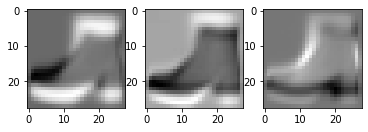

In [ ]:
components_to_view = 3
fig, ax = plt.subplots(nrows = 1, ncols = components_to_view)
for i in range(components_to_view):
  ax[i].imshow(pca.components_[i,:].reshape(28,28), cmap = 'gray')

(784, 784)
[12.09439907+0.j  4.58872545+0.j  3.74873471+0.j  1.99979476+0.j
  1.31679144+0.j  1.04802688+0.j  0.88884489+0.j  0.79067383+0.j
  0.64199964+0.j  0.62015006+0.j]


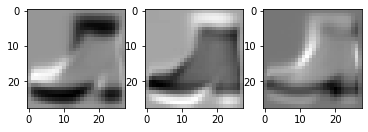

In [ ]:
x_cov = np.cov(np.transpose(x_class))
print(x_cov.shape)
w, v = np.linalg.eig(x_cov)

print(w[0:10])
components_to_view = 3
fig, ax = plt.subplots(nrows = 1, ncols = components_to_view)
for i in range(components_to_view):
  ax[i].imshow(np.real(v[:,i]).reshape(28,28), cmap = 'gray')
#print(np.real(v[:,0]) + pca.components_[:,0])

#Visualisering av PCA

In [1]:
import matplotlib.pyplot as plt
import numpy as np

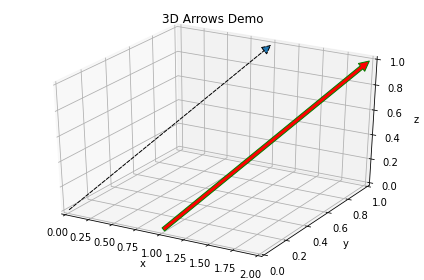

In [2]:
#From: https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0,2)
ax.arrow3D(0,0,0,
           1,1,1,
           mutation_scale=20,
           arrowstyle="-|>",
           linestyle='dashed')
ax.arrow3D(1,0,0,
           1,1,1,
           mutation_scale=20,
           ec ='green',
           fc='red')
ax.set_title('3D Arrows Demo')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.tight_layout()

In [3]:
numberOfSamples = 400
samplesInPCA = np.random.normal(0,1,[400,3])
variances = [np.sqrt(10), np.sqrt(3), np.sqrt(0.3)]
samplesInPCA = samplesInPCA * variances

PCAvectors = np.zeros([3,3])
PCAvectors[:,0] = [1,1,1]
PCAvectors[:,1] = [-1,0,1]
PCAvectors[:,2] = [1,-2,1]

for i in range(3):
  PCAvectors[:,i] = PCAvectors[:,i]/np.linalg.norm(PCAvectors[:,i])
print(samplesInPCA)
print(PCAvectors)

[[11.10538602 -1.36922283  0.29064907]
 [ 1.09415543  1.16436695  0.42073884]
 [ 0.66096259  2.61611859  0.70585629]
 ...
 [ 2.76468565  2.40635393  0.37058987]
 [ 1.43916281 -1.41260973  0.13176086]
 [ 2.3120071   1.70785169  0.43554702]]
[[ 0.57735027 -0.70710678  0.40824829]
 [ 0.57735027  0.         -0.81649658]
 [ 0.57735027  0.70710678  0.40824829]]


(3, 400)


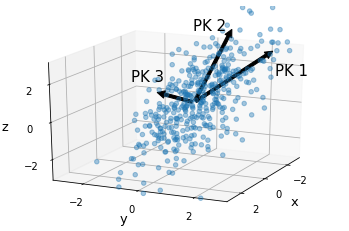

In [4]:
centerPosition = np.transpose(np.array([1,1,1], ndmin = 2))
samplesPositions = np.matmul(PCAvectors,np.transpose(samplesInPCA)) + centerPosition

fig = plt.figure()
ax = fig.gca(projection = '3d')

ax.view_init(20,25)
u = PCAvectors[0,:]*variances
v = PCAvectors[1,:]*variances
w = PCAvectors[2,:]*variances
#ax.quiver(np.ones(3), np.ones(3), np.ones(3), u, v, w, arrow_length_ratio=0.3,length = 3, color = "orange")
ax.set_xlim3d(-3,3)
ax.set_ylim3d(-3,3)
ax.set_zlim3d(-3,3)
ax.set_xlabel("x", fontsize = 13)
ax.set_ylabel("y", fontsize = 13)
ax.set_zlabel("z", fontsize = 13)
ax.set_xticks([-2,0,2])
ax.set_yticks([-2,0,2])
ax.set_zticks([-2,0,2])

for i in range(3):
  scale_factor = 2.5
  dx = PCAvectors[0,i]*scale_factor*variances[i]
  dy = PCAvectors[1,i]*scale_factor*variances[i]
  dz = PCAvectors[2,i]*scale_factor*variances[i]
  ax.arrow3D(centerPosition[0,0], centerPosition[1,0], centerPosition[2,0], dx,dy,dz, mutation_scale = 15, color = "black")
ax.scatter(samplesPositions[0,:], samplesPositions[1,:], samplesPositions[2,:], alpha = 0.4)

textpos1 = centerPosition[:,0] + PCAvectors[:,0]*8
ax.text(textpos1[0], textpos1[1],textpos1[2]-1.2, "PK 1", fontsize = 15, color = "black")
textpos2 = centerPosition[:,0] + PCAvectors[:,1]*4
ax.text(textpos2[0], textpos2[1]-1.35,textpos2[2], "PK 2", fontsize = 15, color = "black")
textpos3 = centerPosition[:,0] + PCAvectors[:,2]*3
ax.text(textpos3[0], textpos3[1]+0.8,textpos3[2], "PK 3", fontsize = 15, color = "black")
#ax.text(3,3,3, "PC 1", PCAvectors[:,0], fontsize = 15, color = "red")
print(samplesPositions.shape)
plt.savefig("PCA_3D.pdf")

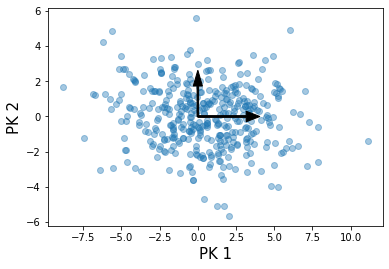

In [5]:
fig = plt.figure()
ax = fig.gca()

ax.scatter(samplesInPCA[:,0],samplesInPCA[:,1], alpha = .4)
ax.arrow(0, 0, variances[0], 0, width = 0.1, color = 'black', head_width = 0.6)
ax.arrow(0, 0, 0, variances[1], width = 0.1, color = 'black', head_width = 0.6)
ax.set_xlabel("PK 1", fontsize = 15)
ax.set_ylabel("PK 2", fontsize = 15)
plt.savefig("PCA_2D.pdf")

##Two classes

In [6]:
numberOfSamples = 400
samplesInPCA = np.random.normal(0,1,[2,400,3])
variances = np.array([[np.sqrt(10), np.sqrt(3), np.sqrt(0.3)],[np.sqrt(10), np.sqrt(3), np.sqrt(0.3)]])
samplesInPCA = samplesInPCA * np.expand_dims(variances,axis = 1)

PCAvectors = np.zeros([2,3,3])
PCAvectors[0,:,0] = [1,1,1]
PCAvectors[0,:,1] = [-1,0,1]
PCAvectors[0,:,2] = [1,-2,1]

PCAvectors[1,:,0] = [1,-3,1]
PCAvectors[1,:,1] = [1,1,2]
PCAvectors[1,:,2] = np.cross(PCAvectors[1,:,0],PCAvectors[1,:,1])

for i in range(3):
  for j in range(2):
    PCAvectors[j,:,i] = PCAvectors[j,:,i]/np.linalg.norm(PCAvectors[j,:,i])
print(samplesInPCA)
print(PCAvectors)


[[[ 0.65218113 -0.98405561  0.00646347]
  [-2.04663055 -2.16056718 -0.62164384]
  [-1.93052654 -0.06221467  0.26360732]
  ...
  [ 1.361199    1.57284986  0.60150882]
  [ 5.22876302  0.13094071 -0.56270978]
  [ 0.37071664  0.22696456 -0.11865628]]

 [[-3.73037818  1.92265709 -0.08516529]
  [-3.61658587 -2.81648733  0.22973815]
  [-1.56320242 -1.41441844  0.5210155 ]
  ...
  [ 4.20941158  0.67788234 -0.45460771]
  [ 5.71258704 -0.66621271 -0.57529742]
  [ 4.42465804  1.33578817 -0.17152749]]]
[[[ 0.57735027 -0.70710678  0.40824829]
  [ 0.57735027  0.         -0.81649658]
  [ 0.57735027  0.70710678  0.40824829]]

 [[ 0.30151134  0.40824829 -0.86164044]
  [-0.90453403  0.40824829 -0.12309149]
  [ 0.30151134  0.81649658  0.49236596]]]


(2, 3, 400)
(2, 3)
(3, 2)
(2, 3, 400)


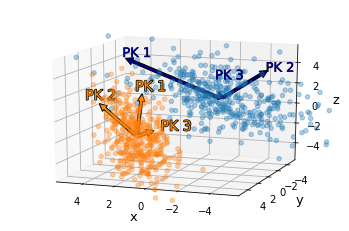

In [7]:
import matplotlib.patheffects as PathEffects
centerPosition = np.transpose(np.array([[-2,-2,1],
                                        [2,2,-2]], ndmin = 2))
samplesPositions = np.zeros([2,3,numberOfSamples])
print(samplesPositions.shape)
print(variances.shape)
print(centerPosition.shape)
for j in range(2):
  samplesPositions[j,:,:] = np.matmul(PCAvectors[j,:,:],np.transpose(samplesInPCA[j,:,:])) + np.expand_dims(centerPosition[:,j],1)

fig = plt.figure()
ax = fig.gca(projection = '3d')
width = 5.5
ax.set_xlim3d(-width,width)
ax.set_ylim3d(-width,width)
ax.set_zlim3d(-width,width)
ax.set_xlabel("x", fontsize = 13)
ax.set_ylabel("y", fontsize = 13)
ax.set_zlabel("z", fontsize = 13)
ax.set_xticks([-4,-2,0,2,4])
ax.set_yticks([-4,-2,0,2,4])
ax.set_zticks([-4,-2,0,2,4])
#ax.quiver(np.ones(3), np.ones(3), np.ones(3), u, v, w, arrow_length_ratio=0.3,length = 3, color = "orange")

ax.view_init(15,110)
colors = ['darkblue','darkorange']
for j in range(2):
  ax.scatter(samplesPositions[j,0,:], samplesPositions[j,1,:], samplesPositions[j,2,:], alpha = 0.35)

for j in range(2):
  u = PCAvectors[j,0,:]*variances[j,:]
  v = PCAvectors[j,1,:]*variances[j,:]
  w = PCAvectors[j,2,:]*variances[j,:]
  for i in range(3):
    scale_factor = 2.5
    dx = PCAvectors[j,0,i]*scale_factor*variances[j,i]
    dy = PCAvectors[j,1,i]*scale_factor*variances[j,i]
    dz = PCAvectors[j,2,i]*scale_factor*variances[j,i]
    ax.arrow3D(centerPosition[0,j], centerPosition[1,j], centerPosition[2,j], dx,dy,dz, mutation_scale = 15, color = colors[j], alpha = 1, ec = 'black')
txt = [None,]*3
textpos1 = centerPosition[:,0] + PCAvectors[0,:,0]*8
txt[0] = ax.text(textpos1[0], textpos1[1],textpos1[2], "PK 1", fontsize = 13, color = colors[0])
textpos2 = centerPosition[:,0] + PCAvectors[0,:,1]*4
txt[1] = ax.text(textpos2[0], textpos2[1],textpos2[2], "PK 2", fontsize = 13, color = colors[0])
textpos3 = centerPosition[:,0] + PCAvectors[0,:,2]*3
txt[2] = ax.text(textpos3[0], textpos3[1],textpos3[2], "PK 3", fontsize = 13, color = colors[0])
#ax.text(3,3,3, "PC 1", PCAvectors[:,0], fontsize = 15, color = "red")
for t in txt:
  t.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])
textpos1 = centerPosition[:,1] + PCAvectors[1,:,0]*8
txt[0] = ax.text(textpos1[0]+0.5, textpos1[1],textpos1[2], "PK 1", fontsize = 14, color = colors[1])
textpos2 = centerPosition[:,1] + PCAvectors[1,:,1]*4
txt[1] = ax.text(textpos2[0]+1, textpos2[1],textpos2[2]+0.4, "PK 2", fontsize = 14, color = colors[1])
textpos3 = centerPosition[:,1] + PCAvectors[1,:,2]*1.7
txt[2] = ax.text(textpos3[0], textpos3[1],textpos3[2]-0.2, "PK 3", fontsize = 14, color = colors[1])
for t in txt:
  t.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='black')])

print(samplesPositions.shape)
plt.savefig("PCA_3D_two_classes.pdf",bbox_inches = 'tight')

(3, 400)
(3, 400)


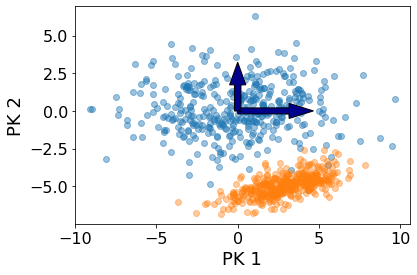

In [8]:
fig = plt.figure()
ax = fig.gca()
print((samplesPositions[1,:,:] - np.expand_dims(centerPosition[:,0],1)).shape)
otherClassSamples = np.matmul(np.transpose(PCAvectors[0,:,:]),(samplesPositions[1,:,:] - np.expand_dims(centerPosition[:,0],1)))
print(otherClassSamples.shape)

ax.scatter(samplesInPCA[0,:,0],samplesInPCA[0,:,1], alpha = .45)
ax.scatter(otherClassSamples[0,:],otherClassSamples[1,:], alpha = .4)
ax.arrow(0, 0, variances[0,0], 0, width = 0.4, color = colors[0], head_width = 1, ec = 'black')
ax.arrow(0, 0, 0, variances[0,1], width = 0.4, color = colors[0], head_width = 1, ec = 'black')
ax.set_xlabel("PK 1", fontsize = 18)
ax.set_ylabel("PK 2", fontsize = 18)
ax.tick_params(axis = 'both', labelsize = 16)
plt.savefig("PCA_2D_two_classes_first.pdf", bbox_inches = 'tight')

(3, 400)
(3, 400)


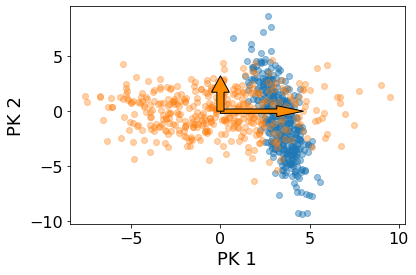

In [9]:
fig = plt.figure()
ax = fig.gca()
print((samplesPositions[1,:,:] - np.expand_dims(centerPosition[:,0],1)).shape)
otherClassSamples = np.matmul(np.transpose(PCAvectors[1,:,:]),(samplesPositions[0,:,:] - np.expand_dims(centerPosition[:,1],1)))
print(otherClassSamples.shape)

ax.scatter(otherClassSamples[0,:],otherClassSamples[1,:], alpha = .45)
ax.scatter(samplesInPCA[1,:,0],samplesInPCA[1,:,1], alpha = .35)
ax.arrow(0, 0, variances[1,0], 0, width = 0.4, color = colors[1], head_width = 1, ec = 'black')
ax.arrow(0, 0, 0, variances[1,1], width = 0.4, color = colors[1], head_width = 1, ec = 'black')
ax.set_xlabel("PK 1", fontsize = 18)
ax.set_ylabel("PK 2", fontsize = 18)

ax.tick_params(axis = 'both', labelsize = 16)
plt.savefig("PCA_2D_two_classes_second.pdf", bbox_inches = 'tight')